In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import sys 
import json
import glob
import random
import collections
import time
import re
import math
import numpy as np
import pandas as pd
import cv2

In [2]:
# Lets read the train data and the train labels. 
train_data_directory = 'D:/Brain_Tumor_Data/train'
data_directory = 'D:/Brain_Tumor_Data'
IMAGE_SIZE = 128
NUM_IMAGES = 64
def load_dicom_image(path, img_size=IMAGE_SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
        
    data = cv2.resize(data, (img_size, img_size))
    return data


def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=IMAGE_SIZE, mri_type="FLAIR", split="test", rotate=0):

    files = sorted(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    return np.expand_dims(img3d,0)


(1, 128, 128, 64)
0.0 1.0 0.06278081447195914 0.00016408131415728857
Dimension of the CT scan is: (128, 128, 64)


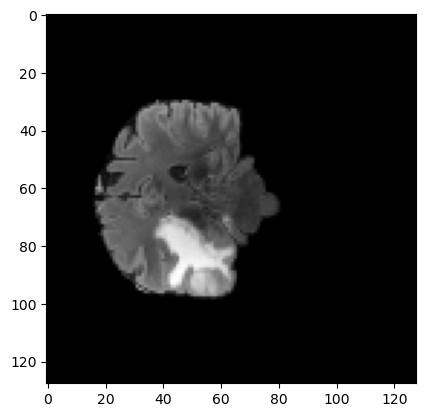

In [3]:
a = load_dicom_images_3d("00001")
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))
image = a[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 15]), cmap="gray")

### EXPLANATION OF ABOVE DEF FUNCTIONS¶
Lets trace how this image is getting loaded by completely following the def function to have a full understanding of what this 3D image

In [5]:
num_imgs=NUM_IMAGES
img_size=IMAGE_SIZE
mri_type="FLAIR"
split="test"
rotate=0
scan_id = "00001"

The below address essentially points out that we should take all the files within 00001 under test folder under flair mri images. We are pointing to all the images within that.

In [6]:
f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"

'D:/Brain_Tumor_Data/test/00001/FLAIR/*.dcm'

In [7]:
key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)]

In [8]:
files = sorted(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
print(files)

['D:/Brain_Tumor_Data/test/00001/FLAIR\\Image-1.dcm', 'D:/Brain_Tumor_Data/test/00001/FLAIR\\Image-2.dcm', 'D:/Brain_Tumor_Data/test/00001/FLAIR\\Image-3.dcm', 'D:/Brain_Tumor_Data/test/00001/FLAIR\\Image-4.dcm', 'D:/Brain_Tumor_Data/test/00001/FLAIR\\Image-5.dcm', 'D:/Brain_Tumor_Data/test/00001/FLAIR\\Image-6.dcm', 'D:/Brain_Tumor_Data/test/00001/FLAIR\\Image-7.dcm', 'D:/Brain_Tumor_Data/test/00001/FLAIR\\Image-8.dcm', 'D:/Brain_Tumor_Data/test/00001/FLAIR\\Image-9.dcm', 'D:/Brain_Tumor_Data/test/00001/FLAIR\\Image-10.dcm', 'D:/Brain_Tumor_Data/test/00001/FLAIR\\Image-11.dcm', 'D:/Brain_Tumor_Data/test/00001/FLAIR\\Image-12.dcm', 'D:/Brain_Tumor_Data/test/00001/FLAIR\\Image-13.dcm', 'D:/Brain_Tumor_Data/test/00001/FLAIR\\Image-14.dcm', 'D:/Brain_Tumor_Data/test/00001/FLAIR\\Image-15.dcm', 'D:/Brain_Tumor_Data/test/00001/FLAIR\\Image-16.dcm', 'D:/Brain_Tumor_Data/test/00001/FLAIR\\Image-17.dcm', 'D:/Brain_Tumor_Data/test/00001/FLAIR\\Image-18.dcm', 'D:/Brain_Tumor_Data/test/00001/FLAI

In [9]:
middle = len(files)//2
num_imgs2 = num_imgs//2
p1 = max(0, middle - num_imgs2)
p2 = min(len(files), middle + num_imgs2)

print(p1,p2)

72 136


choosing 64 images within 72 and 136 i.e my number of Images and stacking them in a numpy array taking their transpose

In [10]:
img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in files[p1:p2]]).T 

In [11]:
img3d.T.shape

(64, 128, 128)

In [12]:
img3d.shape
print(img3d.shape, img3d.shape[-1])

(128, 128, 64) 64


In [13]:
img3d.shape[-1] < num_imgs

False

If the sampled images are less than 64 i.e the number of images then we will put black array of pixels of the same size to take the number of images to 64

In [14]:
if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)

In [15]:
print(np.min(img3d),np.max(img3d))

-32768.0 31445.12315513283


The below operation is basically the scaling of pixels where we subtract the minimum value and divide by the maximum value.

In [16]:
if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)

In [17]:
img3d.shape

(128, 128, 64)

In [18]:
np.expand_dims(img3d,0).T.shape

(64, 128, 128, 1)

### Generate the training Dataset

In [19]:
df_train_labels = pd.read_csv('D:/Brain_Tumor_Data/_labels.csv')
df_train_labels.head()

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


In [20]:
train_data_directory = 'D:/Brain_Tumor_Data/train'
print(min(os.listdir(train_data_directory)), max(os.listdir(train_data_directory)))

00000 01010


Lets not take all 1010 samples for training as this will led to a lot of memory and time consumption hence lets take only 140 samples out of these all. 

use below line of code for all

In [21]:
total_training_scans = np.array([load_dicom_images_3d(a, split = 'train') for a in os.listdir(train_data_directory)])

In [22]:
count = 0
list_train_files = []
for file in os.listdir(train_data_directory):
    if count<140:
        list_train_files.append(file)
        count = count+1

In [23]:
len(list_train_files)

140

In [24]:
total_training_scans = np.array([load_dicom_images_3d(a, split = 'train') for a in list_train_files])

(140, 1, 128, 128, 64)
140
Dimension of the CT scan is: (1, 128, 128, 64)


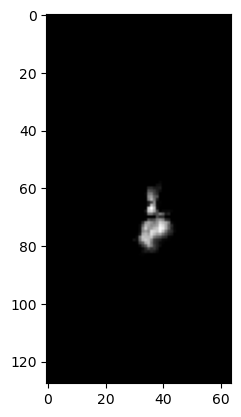

In [25]:
print(total_training_scans.shape)
print(len(total_training_scans))
image = total_training_scans[20]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 25]), cmap="gray")

In [26]:
# Split data in the ratio 70-30 for training and validation.
x_train = np.array([train.T for train in total_training_scans[:100]])
x_val = np.array([train.T for train in total_training_scans[100:]])

In [27]:
x_train.shape

(100, 64, 128, 128, 1)

In [28]:
x_train = x_train[:100]

In [29]:
x_train.shape

(100, 64, 128, 128, 1)

In [30]:
total_training_labels = df_train_labels["MGMT_value"].to_list()

In [31]:
total_training_labels = total_training_labels[:140]

In [32]:
len(total_training_labels)

140

In [33]:
y_train = total_training_labels[:100]
y_val = total_training_labels[100:]

(1, 128, 128, 64)
0.0 1.0 0.06278081447195914 0.00016408131415728857
Dimension of the CT scan is: (128, 128, 64)


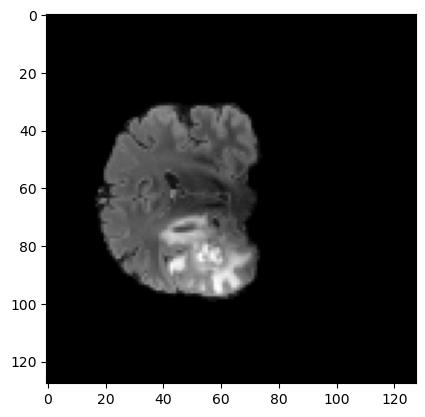

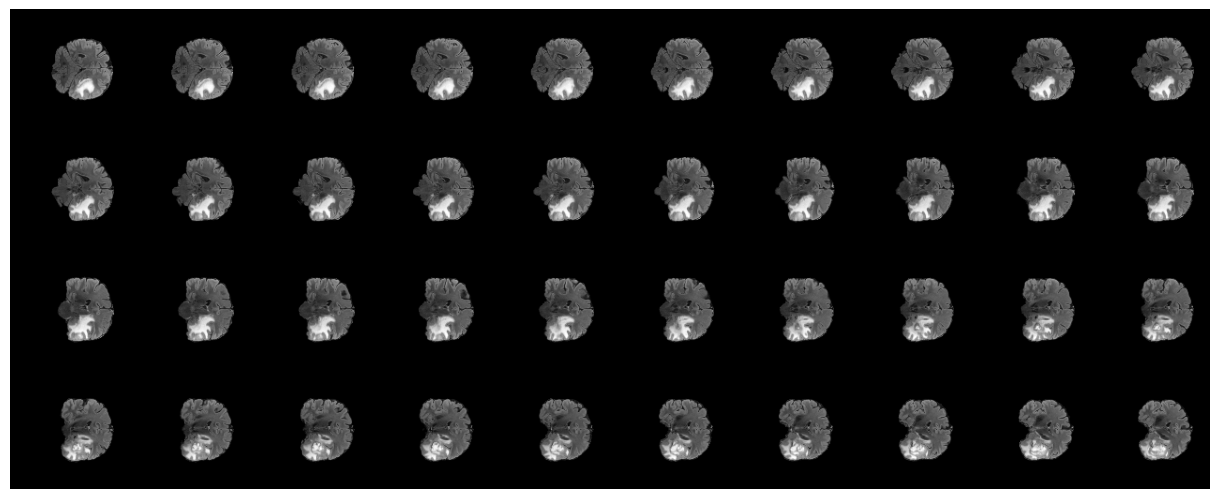

In [34]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
a = load_dicom_images_3d("00001")
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))
image = a[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")
plot_slices(4, 10, 128, 128, image[:, :, :40])

### Model

In [35]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((depth,width, height,1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 128, 128, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 62, 126, 126, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 31, 63, 63, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 31, 63, 63, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 29, 61, 61, 64)    110656    
                                                             

Training it for one epoch because we have a limited memory with this. All above transpose operations has been made in order to provide an input image according to the dimensions we have specified. Also We need to ensure that we provide a batch in order to cover for None in (None, 64,128,128,1).

In [36]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 1
model.fit(
    tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(4),
    validation_data=tf.data.Dataset.from_tensor_slices((x_val,y_val)).batch(4),
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

25/25 - 340s - loss: 0.7147 - acc: 0.5900 - val_loss: 0.7145 - val_acc: 0.4500 - 340s/epoch - 14s/step
